# Modelo: ***CNN (Convolutional Neuronal Networks)***

Modelo_2 utilizaremos una ***CNN creada desde cero***.



In [1]:
import os, sys
sys.path.insert(1, '/content/drive/MyDrive/Colab Notebooks/MAIZ/src/utils') # 1 significa que se añade como la segunda prioridad (la posición 0 es normalmente el directorio actual del script).
                                                                            # Esto asegura que esta carpeta se revisará antes que otras rutas estándar.

In [2]:
# Nos posicionamos en el directorio de trabajo:
os.chdir("/content/drive/MyDrive/Colab Notebooks/MAIZ/src")

In [3]:
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/MAIZ/src


In [4]:
## Librerias
# Data Analysis
import os, sys
sys.path.insert(0, "/content/drive/MyDrive/Colab Notebooks/MAIZ/src/utils")
from collections import Counter
import numpy as np
import pandas as pd
import pickle
from sklearn.utils import shuffle

# Data Preproccesing
from collections import Counter
import pickle
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
from funciones import (cargar_dataset, guardar_dataset,
                       transformacion_datos_X, transformacion_datos_y_OneHotEncoding,transformacion_datos_y_LabelEncoding,
                       dimensiones_imagenes, distribución_x_clase,
                       classification_report, plot_confusion_matrix, plot_ROC_Curve)

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import cv2
import seaborn as sns

# Deep Learning (TensorFlow y tf.keras)
import tensorflow as tf
import tensorflow_hub as hub
from skimage.transform import resize
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Conv2D, Flatten, Dropout,
                                     MaxPooling2D, GlobalAveragePooling2D,
                                     AveragePooling2D, BatchNormalization)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.models import save_model

# Métricas
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve,
                            precision_score, recall_score,
                            f1_score, accuracy_score, roc_curve, auc)

In [5]:
# Rutas de cada dataset: train-test-val:
train_path = "/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/train"
test_path = "/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/test"
val_path = "/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/val"

## **1. Procesamiento de los Datos**


In [6]:
# Lista con las clases:
clases = os.listdir("/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/train")
clases

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

Las redes neuronales convolucionales (CNN) requieren etiquetas de números enteros para entrenarse y etiquetas categóricas para visualizar las predicciones/resultados. Por lo tanto, las transformaremos inicializando dos diccionarios para mapear las etiquetas según la necesidad.

In [7]:
# Diccionarios de Mapeos para las etiquetas:
# para train (a numericas):
clases_a_cat = {0:'Blight',
                        1:'Common_Rust',
                        2:'Gray_Leaf_Spot',
                        3:'Healthy'}

# y para los resultados/predicciones (a categóricas):
clases_a_num = {'Blight':0,
                'Common_Rust':1,
                'Gray_Leaf_Spot':2,
                'Healthy':3}

### Definimos las variables ***X***, ***y***

In [8]:
def creacion_listas_X_y(folder_path):
  X = []
  y = []
  #Lista con los nombres de cada clase:
  clases = os.listdir("/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/train")
  # Definimos las dimensiones de las imágenes
  img_width, img_height = 224, 224 # image_size

  # Iteramos en clases
  for class_name in clases: # lista nombres clases
    # Lista de las imagenes
    images_names = os.listdir(folder_path +'/'+ class_name)
    # Iteramos en las imagenes
    for img_name in images_names:
      image_path = folder_path +'/'+ class_name +'/'+ img_name # ruta de la imagen
      image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) # pasamos la imagen a array con la imagen a color
      image = cv2.resize(image_array, (img_width, img_height)) # data preprocessing
      image = np.array(image) # usamos numpy para tener la imagen en array
      image = image.astype('float32') # pasamos la imagen a tipo 'float32'
      X.append(image) # agregamos la imagen a X
      y.append(class_name) # agregamos su nombre/target a y

  return X, y # retornamos una tupla con los valores (X, y)

In [9]:
# Creamos X, y:
X_train, y_train = creacion_listas_X_y(train_path)
X_test, y_test = creacion_listas_X_y(test_path)
X_val, y_val = creacion_listas_X_y(val_path)

### ***X***

In [10]:
# Procesamos X_train, X_test, X_val:
X_train, X_test, X_val = transformacion_datos_X(X_train, X_test, X_val)

In [11]:
# Visualizamos las dimensiones en train
X_train_shapes = dimensiones_imagenes(X_train)
print("X_train:  {} tipos de dimensiones".format(len(X_train_shapes)))

(224, 224, 3) --> 3348 imagenes
X_train:  1 tipos de dimensiones


### ***y*** : Target

Aplicamos la transformacion de la target a vectores binarios one-hot.

In [11]:
# Procesamos y_train, y_test, y_val:
y_train, y_test, y_val = transformacion_datos_y_OneHotEncoding(y_train, y_test, y_val)

Visualizamos el shape de y_train e y_test:

In [13]:
# Visualizamos las dimensiones
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))
print("y_val: {}".format(y_val.shape))

y_train: (3348, 4)
y_test: (423, 4)
y_val: (417, 4)


Como las imagenes están cargadas de forma ordenada vamos a mezclarlas aleatoriamente con el Metodo `shuffle`

In [12]:
# Utilizamos una semilla aleatoria fija (random seed).
# Esto garantiza que la secuencia de desordenamiento sea siempre la misma en cada ejecución.
seed = 23
X_train, y_train = shuffle(X_train, y_train, random_state=seed)
X_test, y_test = shuffle(X_test, y_test, random_state=seed)
X_val, y_val = shuffle(X_val, y_val, random_state=seed)

##### ***Definimos los class_weights***


Calculamos manualmente los pesos aplicando la fórmula:

In [13]:
train_path = "/content/drive/MyDrive/Colab Notebooks/MAIZ/src/data/data_splitted/train"
df_train = distribución_x_clase(train_path)

# Pesos originales
df_train['original_weights'] = df_train['N° of Images'] / df_train['N° of Images'].sum()

# Pesos definidos
df_train['new_weights'] = df_train['N° of Images'].sum()/(len(clases)*df_train['N° of Images'])
df_train

,Class_Name,N° of Images,original_weights,new_weights
0,Blight,916,0.273596,0.913755
1,Common_Rust,1044,0.311828,0.801724
2,Gray_Leaf_Spot,459,0.137097,1.823529
3,Healthy,929,0.277479,0.900969


In [14]:
# Creamos un diccionario con los pesos para cada clase:
class_weights = {i : df_train['new_weights'][i] for i in range(len(df_train))}
class_weights

{0: 0.9137554585152838,
 1: 0.8017241379310345,
 2: 1.8235294117647058,
 3: 0.9009687836383208}

# **Modelos** ***CNN***

## **Versión 1**

A continuación se probó una red neuronal simple con distintos tipos de capas.

Las capas constan de:
* `Conv2D`:
* `MaxPooling2D`:
* `Conv2D`:
* `MaxPooling2D`:
* `Flatten`:
* `Dropout`:
* `Dense`:

Junto con estas capas, el `Adam optimizer` y `sparse_categorical_crossentropy` compilarán nuestro modelo.


### **1. Definición del Modelo**

In [18]:
# Modelo Secuencial:
model = Sequential()

model.add(tf.keras.layers.InputLayer(shape=(224, 224, 3)))


# Añadimos las capas ocultas y la final
model.add(Conv2D(32, padding='same', kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, padding='same', kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(len(clases), activation='softmax'))

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │         802,820 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 822,212 (3.14 MB)

 Trainable params: 822,212 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Compilamos
model.compile(optimizer='adam',
                loss='categorical_crossentropy', # Esta función de pérdida se utiliza cuando las etiquetas son enteros codificados como unicos ("one-hot encoded") para cada clase.
                metrics=['accuracy'])

### **2. Entrenamiento del Modelo**

Iniciamos con una `callback` para detener la adaptación cuando ya no se produzcan mejoras significativas en `loss` por 3 epochs consecutivas.<br>
`restore_best_weights=True`: esto nos ayudará a mantener los mejores pesos al final del entrenamiento.

In [21]:
# Indicamos el Early-Stopping: patience indica que cuando se repite n veces que frene
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)
n_epochs = 30

model_hist = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        batch_size=128,
                        epochs=n_epochs,
                        callbacks= callback)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 512ms/step - accuracy: 0.4740 - loss: 1.9307 - val_accuracy: 0.8061 - val_loss: 0.5163
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.8337 - loss: 0.4392 - val_accuracy: 0.8061 - val_loss: 0.4325
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.8521 - loss: 0.3444 - val_accuracy: 0.8534 - val_loss: 0.3553
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.8828 - loss: 0.3005 - val_accuracy: 0.8511 - val_loss: 0.3370
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9064 - loss: 0.2473 - val_accuracy: 0.8511 - val_loss: 0.3592
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9219 - loss: 0.1934 - val_accuracy: 0.8582 - val_loss: 0.3302
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.9390 - loss: 0.1798 - val_accuracy: 0.8582 - val_loss: 0.3747
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9496 - loss: 0.1488 - val_accuracy: 

### **Guardado del Modelo** (este apartado ponerlo a lo ultimo)

In [ ]:
from tensorflow.keras.models import save_model

In [ ]:
# Guardamos nuestro modelo en la carpeta 'models'
save_model(model_0,"/content/drive/MyDrive/Colab Notebooks/MAIZ/src/models/model_0_cnn.keras")

In [ ]:
# Cargamos el modelo
model_0 = keras.saving.load_model("/content/drive/MyDrive/Colab Notebooks/MAIZ/src/models/model_0_cnn.keras")

### **3. Evaluación del Modelo**
Parece que el modelo se está sobreajustando
(*Overfitting*) a los datos del train (memoriza en lugar de aprender patrones generalizables), pero a pesar de eso, la evaluación con respecto a los datos del test es muy buena.


#### **Accuracy - Loss**

In [22]:
# Tupla con los valores: (val_loss, val_accuracy):
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest loss:', round(test_loss,4))
print('Test accuracy:', round(test_acc,4))

14/14 - 3s - 188ms/step - accuracy: 0.8818 - loss: 0.5885

Test loss: 0.5885
Test accuracy: 0.8818


#### **Gráfico Train y Test Accuracy y Loss**

In [23]:
# Creamos un df con el history del modelo:
# Diccionario con los valores: las keys son loss - sparse_categorical_accuracy - val_loss - val_sparse_categorical_accuracy
model_hist.history

# Para ver las keys
model_hist.history.keys()

# Creamos un df con la info
df_history = pd.DataFrame(model_hist.history)
df_history

,accuracy,loss,val_accuracy,val_loss
0,0.629928,1.238385,0.806147,0.516294
1,0.828256,0.424547,0.806147,0.432471
2,0.857826,0.331616,0.853428,0.355335
3,0.887993,0.288442,0.851064,0.336996
4,0.911290,0.234544,0.851064,0.359199
5,0.927419,0.196260,0.858156,0.330159
6,0.942055,0.175098,0.858156,0.374743
7,0.950418,0.147383,0.855792,0.327086
8,0.965651,0.116962,0.874704,0.325634
9,0.975806,0.092128,0.874704,0.360616


Text(0.5, 1.0, 'Training and Validation - Accuracy')

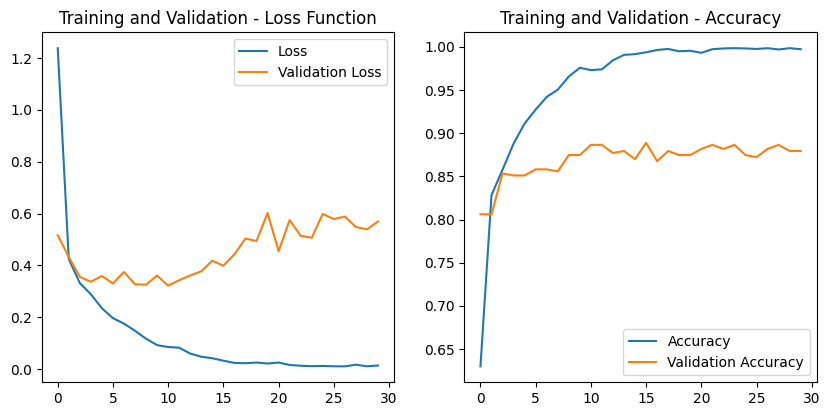

In [24]:
# Graficos Train-Test Accuracy y Loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(model_hist.history['loss'], label='Loss')
plt.plot(model_hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(model_hist.history['accuracy'], label='Accuracy')
plt.plot(model_hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation - Accuracy')

#### **Predicciones**

In [25]:
# obtenemos las probabilidades de cada clase en cada imagen predicha
predicciones = model.predict(X_test)
predicciones

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


array([[9.8342967e-01, 8.0830227e-07, 1.6569471e-02, 1.6610076e-19],
       [9.9995816e-01, 8.2446627e-07, 4.1005918e-05, 6.9890177e-11],
       [1.7453366e-03, 2.9423142e-09, 9.9825460e-01, 2.9910251e-14],
       ...,
       [9.9986041e-01, 1.1862797e-05, 1.2760388e-04, 8.8887552e-12],
       [5.2543795e-14, 1.0000000e+00, 1.5333867e-15, 0.0000000e+00],
       [7.3528138e-04, 3.8429466e-04, 9.9888045e-01, 3.4613680e-27]],
      dtype=float32)

Las `predicciones` es un array en el cual por cada imagen tenemos 4 probabilidades, la más alta corresponde a la clase predicha en esa imágen.

In [26]:
# observamos la dimension (n° de imagenes, n° de probabilidades/clases):
predicciones.shape

(423, 4)

In [27]:
# extraemos la probabilidad mas alta de cada imagen
y_pred = np.argmax(predicciones, axis=1) # model.predict(X_test): obtenemos las probabilidades de cada clase en cada imagen.
                                         # axis=1 para encontrar el índice del valor/probabilidad máxima en cada fila del array

In [28]:
# Convertimos y_test de one-hot(binario) a label-encoder(multiclase)
y_test = np.argmax(y_test, axis=1).reshape(-1,1) # (shape: (423,))

In [29]:
# Para cambiar la dimension, que sea igual a la predicha:
y_test = y_test.reshape(len(y_test)) # otra forma: y_test.shape = y_pred.shape

In [30]:
y_pred

array([0, 0, 2, 3, 2, 3, 1, 0, 0, 0, 3, 3, 3, 1, 0, 0, 3, 2, 1, 0, 3, 3,
       3, 2, 1, 0, 2, 0, 0, 3, 1, 1, 1, 3, 3, 3, 3, 3, 2, 0, 1, 3, 0, 3,
       1, 1, 1, 3, 3, 1, 3, 3, 0, 1, 3, 1, 1, 1, 2, 3, 2, 2, 0, 0, 1, 0,
       3, 1, 1, 3, 1, 0, 0, 3, 0, 1, 2, 3, 0, 2, 2, 1, 1, 1, 3, 1, 1, 1,
       2, 0, 0, 0, 0, 3, 1, 0, 0, 3, 3, 2, 0, 3, 3, 1, 1, 0, 1, 1, 3, 1,
       0, 3, 0, 0, 1, 1, 2, 0, 3, 0, 2, 3, 0, 0, 1, 1, 0, 1, 2, 0, 3, 3,
       3, 1, 2, 1, 1, 0, 0, 3, 3, 0, 0, 1, 2, 0, 3, 3, 1, 3, 3, 3, 1, 1,
       3, 1, 1, 2, 1, 1, 1, 3, 0, 1, 3, 2, 2, 1, 3, 3, 0, 0, 1, 1, 2, 1,
       0, 2, 2, 1, 3, 3, 0, 0, 1, 0, 0, 3, 0, 1, 2, 1, 0, 3, 3, 1, 2, 1,
       1, 1, 1, 1, 3, 2, 0, 0, 3, 3, 1, 3, 0, 1, 1, 0, 1, 0, 0, 3, 3, 0,
       2, 3, 0, 1, 0, 1, 1, 2, 1, 0, 1, 3, 0, 1, 2, 3, 0, 1, 3, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 3, 3, 0, 0, 1, 1, 3, 0, 0, 0, 1, 1, 1, 1, 2,
       1, 3, 3, 0, 3, 1, 1, 2, 1, 0, 3, 2, 1, 1, 1, 3, 1, 0, 0, 3, 3, 3,
       1, 0, 3, 1, 0, 2, 3, 1, 0, 0, 1, 0, 0, 2, 2,

#### **Classification Report**

In [31]:
# Primero debemos mapear y_pred e y_test a variables categoricas:
y_pred = [clases_a_cat[prediccion] for prediccion in y_pred] # Transformamos las predicciones de las imagenes en formato categorico (nombres de las clases)
y_test = [clases_a_cat[y_num] for y_num in y_test] # Transformamos de numerico a categorica los valores de y_test

In [32]:
informe = classification_report(y_test, y_pred)
print(informe)

                precision    recall  f1-score   support

        Blight       0.79      0.86      0.83       116
   Common_Rust       0.96      0.93      0.95       132
Gray_Leaf_Spot       0.64      0.59      0.61        58
       Healthy       1.00      0.99      1.00       117

      accuracy                           0.88       423
     macro avg       0.85      0.84      0.85       423
  weighted avg       0.88      0.88      0.88       423



In [33]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))

Accuracy: 0.88
Precision: 0.88
Recall: 0.88


#### **Matriz de Confusión**<br>
El proposito de la Matriz de Confusion es analizar en profundidad la eficiencia del modelo para predecir cada clase. Los valores de la diagonal principal representan aquellos valores predichos correctamente, mientras que los restantes representan predicciones erroneas en las que el modelo predijo una clase (eje horizontal) pero que en realidad correspondian a otra clase (eje vertical).

In [34]:
def plot_confusion_matrix(y_test, y_pred, title='Matriz de Confusión'):
    # Clases:
    clases = ['Blight','Common_Rust','Gray_Leaf_Spot','Healthy']
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Calcular los porcentajes
    # cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Configurar el gráfico
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='BuGn', xticklabels=clases, yticklabels=clases)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)
    plt.ylabel('True label')
    plt.yticks(rotation=0)
    plt.show()

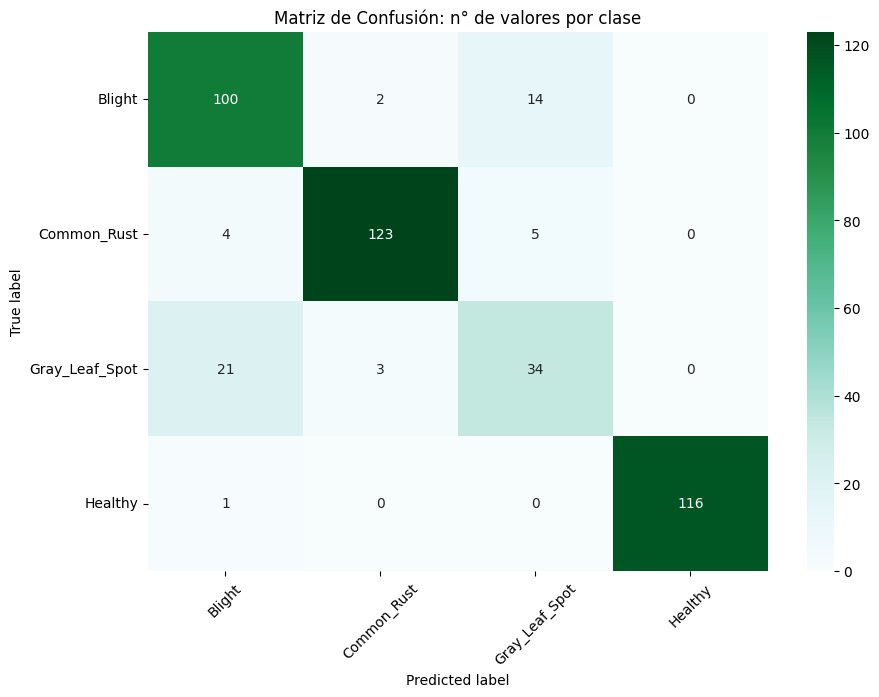

In [35]:
# Generar la matriz de confusión
plot_confusion_matrix(y_test, y_pred,title='Matriz de Confusión: n° de valores por clase')

In [36]:
# valores de la diagonal principal:
diagonal_sum = np.trace(confusion_matrix(y_test, y_pred))
print("Predicciones correctas: {}".format(diagonal_sum)) # suma de valores de la diagonal principal
print("Predicciones erroneas: {}".format(len(y_pred)-diagonal_sum)) # suma de valores fuera de la diagonal principaldiagonal_sum

Predicciones correctas: 373
Predicciones erroneas: 50


In [37]:
# Crearemos una Matriz de Confusion con los % predichos para cada clase:
cm = confusion_matrix(y_test, y_pred) # creamos la Matriz de Confusion

# Calculamos los % de cada clase
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Redondear los valores a 1 decimal
cm_percent_rounded = np.round(cm_percent, 1)

# Convertir los valores redondeados a cadenas de caracteres
cm_percent_str = np.char.mod('%.1f', cm_percent_rounded)

# Agregamos el simbolo % a cada valor:
cm_porcentajes = np.char.add(cm_percent_str, '%')
cm_porcentajes

array([['86.2%', '1.7%', '12.1%', '0.0%'],
       ['3.0%', '93.2%', '3.8%', '0.0%'],
       ['36.2%', '5.2%', '58.6%', '0.0%'],
       ['0.9%', '0.0%', '0.0%', '99.1%']], dtype='<U5')

Nuestro modelo confunde 59 imagenes, las cuales pertenecen a las clases enfermas `Blight`, `Common_Rust`, `Gray_Leaf_Spot`.<br>
La clase `Healthy` la predice perfectamente sin ningún error.<br>
Lo que significa que a pesar de equivocarse en el tipo de enfermedad, nuestro modelo predice a la perfección si un cultivo esta enfermo o sano.<br>

#### **ROC Curve/AUC**


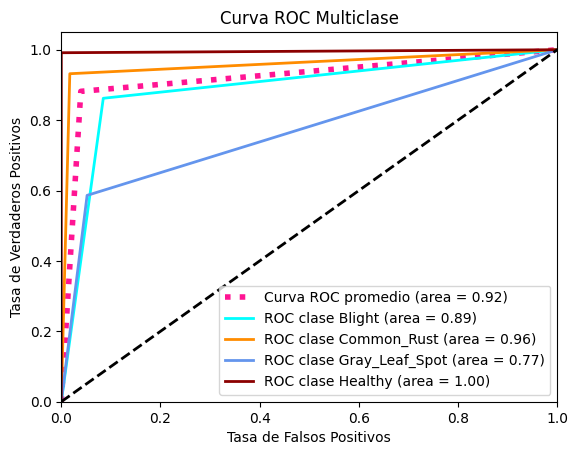

In [38]:
plot_ROC_Curve(y_pred, y_test)

## **Version 2**

Referencias: [***pyimagesearch***](https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)


Tecnicas aplicadas:
* Data Augmentation
* Class Weights

### **1. Definición del Modelo**

In [13]:
model = Sequential()

# our first CONV layer will learn a total of 16 filters, each
# Of which are 7x7 -- we'll then apply 2x2 strides to reduce
# the spatial dimensions of the volume
model.add(Conv2D(16, kernel_size=(7, 7),strides=(2, 2),
                 padding="same", activation='relu', kernel_initializer='he_normal',
                 kernel_regularizer=l2(0.0005), input_shape=(224,224,3)
                 ))

# here we stack two CONV layers on top of each other where
# each layerswill learn a total of 32 (3x3) filters
model.add(Conv2D(32, (3, 3), padding="same", activation='relu',
			          kernel_initializer='he_normal', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same", activation='relu',
			          kernel_initializer='he_normal', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

# stack two more CONV layers, keeping the size of each filter
# as 3x3 but increasing to 64 total learned filters
model.add(Conv2D(64, (3, 3), padding="same",activation='relu',
			    kernel_initializer='he_normal', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation='relu',
			    kernel_initializer='he_normal', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

# increase the number of filters again, this time to 128
model.add(Conv2D(128, (3, 3), padding="same", activation='relu',
			    kernel_initializer='he_normal', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation='relu',
			kernel_initializer='he_normal', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

# fully-connected layer
model.add(Flatten())
model.add(Dense(512, kernel_initializer='he_normal', activation='relu' ))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# output layer
model.add(Dense(len(clases), activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 112, 112, 16)        │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 13,144,580 (50.14 MB)

 Trainable params: 13,142,660 (50.14 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [15]:
# Compilamos: definimos loss and optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### **2. Entrenamiento del Modelo**

In [16]:
# Indicamos el Early-Stopping: patience indica que cuando se repite n veces que frene
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)
n_epochs = 30

model_hist = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        batch_size=128,
                        epochs=n_epochs,
                        callbacks= callback)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 992ms/step - accuracy: 0.7204 - loss: 1.5512 - val_accuracy: 0.2766 - val_loss: 47.4114
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 152ms/step - accuracy: 0.8594 - loss: 0.8272 - val_accuracy: 0.2766 - val_loss: 33.2597
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.8958 - loss: 0.7269 - val_accuracy: 0.2837 - val_loss: 12.2360
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.9280 - loss: 0.6467 - val_accuracy: 0.2861 - val_loss: 8.9764
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9498 - loss: 0.5984 - val_accuracy: 0.2813 - val_loss: 11.4194
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9592 - loss: 0.5551 - val_accuracy: 0.4728 - val_loss: 3.2862
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.9660 - loss: 0.5456 - val_accuracy: 0.5366 - val_loss: 3.4522
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.9829 - loss: 0.5039 - val_accura

### **3. Evaluación del Modelo**


#### **Accuracy - Loss**

In [18]:
# Tupla con los valores: (val_loss, val_accuracy):
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest loss:', round(test_loss,4))
print('Test accuracy:', round(test_acc,4))

14/14 - 8s - 553ms/step - accuracy: 0.7116 - loss: 1.7216

Test loss: 1.7216
Test accuracy: 0.7116


#### **Predicciones**

In [19]:
y_pred = np.argmax(model.predict(X_test), axis=1) # model.predict(X_test): obtenemos las probabilidades de cada clase en cada imagen.
                                                  # axis=1 para encontrar el índice del valor/probabilidad máxima en cada fila del array

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


In [20]:
# Convertimos y_test de one-hot(binario) a label-encoder(multiclase)
y_test = np.argmax(y_test, axis=1).reshape(-1,1) # (shape: (423,))

In [21]:
# Para cambiar la dimension, que sea igual a la predicha:
y_test = y_test.reshape(len(y_test)) # otra forma: y_test.shape = y_pred.shape

In [22]:
y_pred

array([0, 0, 0, 3, 0, 3, 1, 0, 0, 0, 3, 3, 3, 3, 0, 0, 3, 1, 0, 0, 3, 3,
       3, 0, 0, 0, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 0, 0, 1, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 0, 3, 1, 0, 3, 0, 3, 3, 0, 0, 3,
       3, 1, 1, 3, 1, 0, 0, 3, 0, 1, 3, 3, 0, 0, 0, 1, 0, 3, 3, 1, 1, 0,
       0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 3, 0, 0, 3, 3, 1, 1, 0, 3, 1, 3, 1,
       0, 3, 0, 2, 1, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 1, 0, 1, 3, 0, 3, 3,
       3, 1, 0, 3, 1, 2, 0, 3, 3, 0, 0, 0, 3, 0, 3, 3, 1, 3, 3, 3, 1, 1,
       3, 1, 1, 0, 3, 0, 1, 3, 0, 1, 3, 2, 2, 1, 3, 3, 1, 0, 1, 3, 0, 0,
       0, 0, 2, 0, 3, 3, 0, 3, 1, 0, 0, 3, 0, 0, 2, 1, 3, 3, 3, 1, 0, 3,
       3, 1, 3, 1, 3, 0, 0, 0, 3, 3, 0, 3, 0, 3, 1, 0, 0, 0, 0, 3, 3, 0,
       2, 3, 0, 1, 0, 1, 1, 0, 1, 0, 1, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 0,
       0, 3, 1, 0, 1, 0, 0, 3, 3, 1, 3, 3, 1, 3, 0, 0, 0, 1, 1, 3, 3, 0,
       3, 3, 3, 0, 3, 1, 1, 0, 1, 3, 3, 0, 1, 0, 3, 3, 1, 0, 0, 3, 3, 3,
       0, 0, 3, 1, 0, 0, 3, 1, 0, 0, 3, 0, 0, 2, 3,

#### **Classification Report**

In [23]:
# Primero debemos mapear y_pred e y_test a variables categoricas:
y_pred = [clases_a_cat[prediccion] for prediccion in y_pred] # Transformamos las predicciones de las imagenes en formato categorico (nombres de las clases)
y_test = [clases_a_cat[y_num] for y_num in y_test] # Transformamos de numerico a categorica los valores de y_test

In [24]:
informe = classification_report(y_test, y_pred)
print(informe)

                precision    recall  f1-score   support

        Blight       0.67      0.86      0.75       116
   Common_Rust       0.96      0.57      0.71       132
Gray_Leaf_Spot       0.82      0.16      0.26        58
       Healthy       0.64      1.00      0.78       117

      accuracy                           0.71       423
     macro avg       0.77      0.65      0.63       423
  weighted avg       0.77      0.71      0.68       423



In [25]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))

Accuracy: 0.71
Precision: 0.77
Recall: 0.71


#### **Gráfico Train y Test Accuracy y Loss**

In [28]:
# Creamos un df con el history del modelo:
# Diccionario con los valores: las keys son loss - sparse_categorical_accuracy - val_loss - val_sparse_categorical_accuracy
model_hist.history

# Para ver las keys
model_hist.history.keys()

# Creamos un df con la info
df_history = pd.DataFrame(model_hist.history)
df_history

,accuracy,loss,val_accuracy,val_loss
0,0.775986,1.282157,0.276596,47.411369
1,0.866487,0.803798,0.276596,33.259739
2,0.901135,0.714115,0.283688,12.236041
3,0.931302,0.642241,0.286052,8.976364
4,0.946834,0.594859,0.281324,11.419405
5,0.958483,0.556587,0.472813,3.286236
6,0.968638,0.542092,0.536643,3.452199
7,0.981481,0.499804,0.550827,2.906687
8,0.968339,0.526938,0.390071,5.448941
9,0.974014,0.503729,0.456265,4.687141


Text(0.5, 1.0, 'Training and Validation - Accuracy')

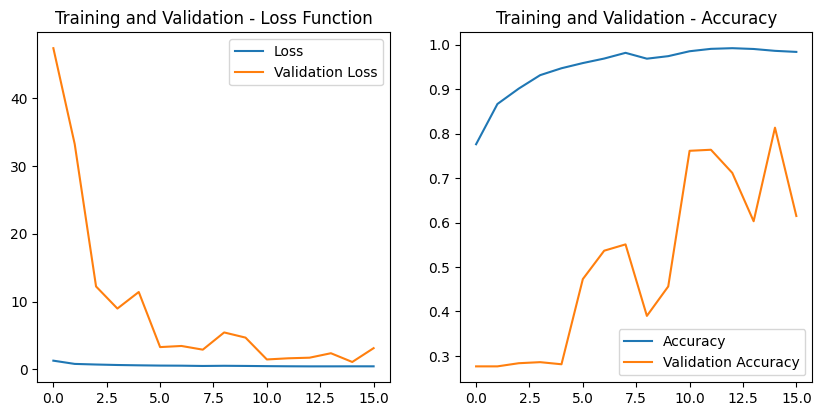

In [29]:
# Graficos Train-Test Accuracy y Loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(model_hist.history['loss'], label='Loss')
plt.plot(model_hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(model_hist.history['accuracy'], label='Accuracy')
plt.plot(model_hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation - Accuracy')

#### **Matriz de Confusión**<br>

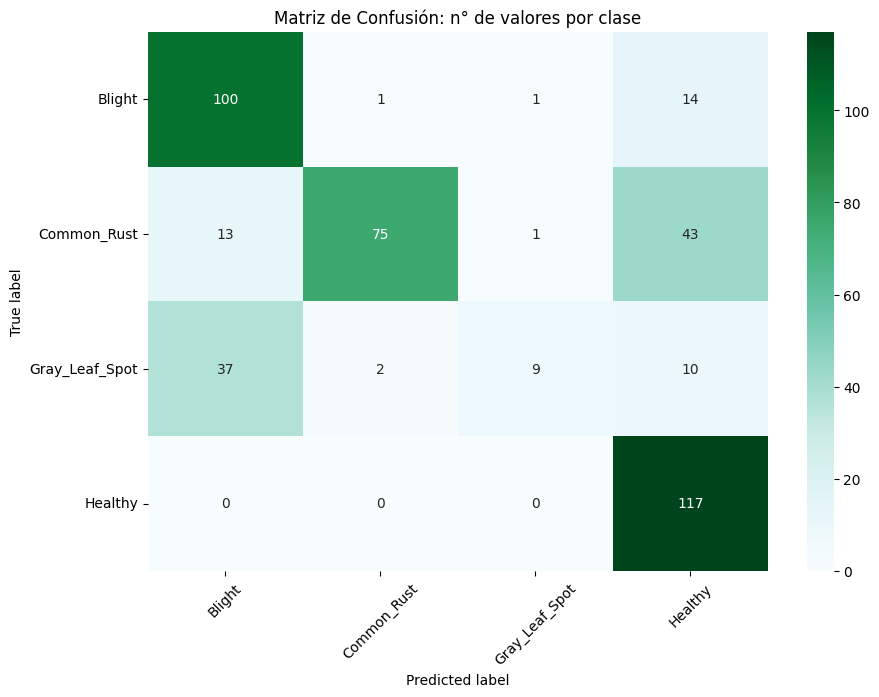

In [30]:
# Generar la matriz de confusión
plot_confusion_matrix(y_test, y_pred,title='Matriz de Confusión: n° de valores por clase')

In [31]:
# valores de la diagonal principal:
diagonal_sum = np.trace(confusion_matrix(y_test, y_pred))
print("Predicciones correctas: {}".format(diagonal_sum)) # suma de valores de la diagonal principal
print("Predicciones erroneas: {}".format(len(y_pred)-diagonal_sum)) # suma de valores fuera de la diagonal principaldiagonal_sum

Predicciones correctas: 301
Predicciones erroneas: 122


In [32]:
# Crearemos una Matriz de Confusion con los % predichos para cada clase:
cm = confusion_matrix(y_test, y_pred) # creamos la Matriz de Confusion

# Calculamos los % de cada clase
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Redondear los valores a 1 decimal
cm_percent_rounded = np.round(cm_percent, 1)

# Convertir los valores redondeados a cadenas de caracteres
cm_percent_str = np.char.mod('%.1f', cm_percent_rounded)

# Agregamos el simbolo % a cada valor:
cm_porcentajes = np.char.add(cm_percent_str, '%')
cm_porcentajes

array([['86.2%', '0.9%', '0.9%', '12.1%'],
       ['9.8%', '56.8%', '0.8%', '32.6%'],
       ['63.8%', '3.4%', '15.5%', '17.2%'],
       ['0.0%', '0.0%', '0.0%', '100.0%']], dtype='<U6')

#### **ROC Curve**

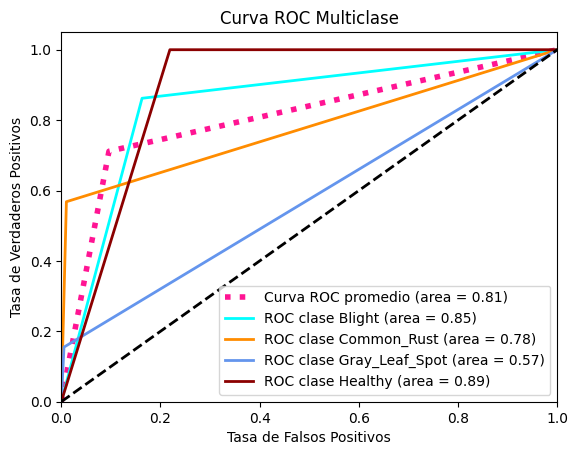

In [33]:
plot_ROC_Curve(y_pred, y_test)

********
## **Referencias**